In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import ceil
import json

In [3]:
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
import torchvision

In [4]:
from metrics import Metric, WassersteinApproximation, StructuralDissimilarity, L2Metric, LinfMetric, LpMetric 

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(1024, 200),
            nn.ReLU(),
            nn.Linear(200, 10),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.seq(x)

In [6]:
model = torch.load('models\\model_v1.model')

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        'mnist',
        train=True,
        download=True,
        transform=torchvision.transforms.ToTensor()
    ),
    batch_size=50,
    shuffle=True
)

In [7]:
def get_benign_examples(model, dataloader, count):
    counter = 0
    benign_examples = torch.zeros(count, 1, dataloader.dataset[0][0].shape[1], dataloader.dataset[0][0].shape[2])
    benign_labels = torch.zeros(count)
    for examples, labels in dataloader:
        preds = model(examples)
        match = (torch.argmax(preds, dim=1) == labels)
        for idx, foo in enumerate(match):
            if foo:
                benign_examples[counter] = examples[idx]
                benign_labels[counter] = labels[idx]
                counter += 1
            if counter >= count:
                break
        if counter >= count:
            break
    return benign_examples, benign_labels

In [14]:
batch = 20

benign, labels = get_benign_examples(model, train_loader, batch)


In [9]:
def cw_batch(model: nn.Module, benign_examples: torch.Tensor, labels: torch.Tensor, c_lambda: float, metric: Metric) -> torch.Tensor:
    adversarial_examples = 0.5 * torch.ones(benign_examples.shape) + 0.3 * (2 * torch.rand(benign_examples.shape) - 1)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    step_size = 1e-2
    for i in range(100):
        adversarial_examples.requires_grad = True
        if adversarial_examples.grad is not None:
            adversarial_examples.grad.zero_()
        benign_examples.requires_grad = True
        if benign_examples.grad is not None:
            benign_examples.grad.zero_()
        metrics = metric(benign_examples, adversarial_examples)
        # if (i + 1) % 10 == 0:
        #     print(metrics)
        loss = metrics.sum() - c_lambda * loss_fn(model(adversarial_examples), torch.tensor(labels, dtype=torch.long))
        
        loss.backward()
        # if (i + 1) % 10 == 0:
        #     print(adversarial_examples.grad)
        adversarial_examples = (adversarial_examples - step_size * adversarial_examples.grad.apply_(lambda x: 1 if x >= 0 else -1)).detach()
        # ex = adversarial_examples[0].detach().reshape(28, 28)
        # if (i + 1) % 10 == 0:   
        #     plt.imshow(ex, cmap='gray', vmin=0, vmax=1)
        #     plt.show()
    return adversarial_examples

In [12]:
lambdas = [1000, 100, 10, 1, 0.1, 0.01, 0.001]

metrics = []

metrics.append(
    {
        'metric': LpMetric(p=1),
        'name': 'L1'
    }
)

metrics.append(
    {
        'metric': L2Metric(),
        'name': 'L2'
    }
)
metrics.append(
    {
        'metric': LinfMetric(),
        'name': 'Linf'
    }
)

# DSSIM
for window_size in [5, 13, 21, 28]:
    metrics.append(
        {
            'metric': StructuralDissimilarity(window_size=window_size),
            'name': f'DSSIM_ws{window_size}'
        }
    )

C:\Users\stani\AppData\Local\Temp\ipykernel_19000\3669848702.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = metrics.sum() - c_lambda * loss_fn(model(adversarial_examples), torch.tensor(labels, dtype=torch.long))


___DONE lambda = 1000
___DONE lambda = 100
___DONE lambda = 10
___DONE lambda = 1
___DONE lambda = 0.1
___DONE lambda = 0.01
___DONE lambda = 0.001
DONE metric L1
___DONE lambda = 1000
___DONE lambda = 100
___DONE lambda = 10
___DONE lambda = 1
___DONE lambda = 0.1
___DONE lambda = 0.01
___DONE lambda = 0.001
DONE metric L2
___DONE lambda = 1000
___DONE lambda = 100
___DONE lambda = 10
___DONE lambda = 1
___DONE lambda = 0.1
___DONE lambda = 0.01
___DONE lambda = 0.001
DONE metric Linf
___DONE lambda = 1000
___DONE lambda = 100
___DONE lambda = 10
___DONE lambda = 1
___DONE lambda = 0.1
___DONE lambda = 0.01
___DONE lambda = 0.001
DONE metric DSSIM_ws5
___DONE lambda = 1000
___DONE lambda = 100
___DONE lambda = 10
___DONE lambda = 1
___DONE lambda = 0.1
___DONE lambda = 0.01
___DONE lambda = 0.001
DONE metric DSSIM_ws13
___DONE lambda = 1000
___DONE lambda = 100
___DONE lambda = 10
___DONE lambda = 1
___DONE lambda = 0.1
___DONE lambda = 0.01
___DONE lambda = 0.001
DONE metric DSSIM_ws

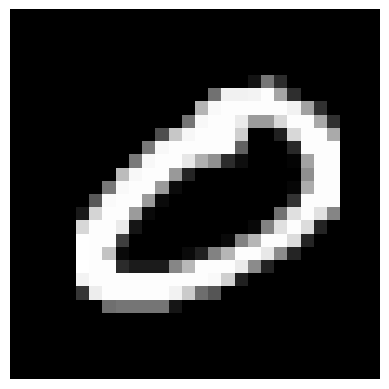

In [15]:
l2 = L2Metric()

for metric in metrics:
    for lambd in lambdas:
        adv = cw_batch(model, benign, labels, lambd, metric['metric'])
        metric['adv'] = adv
        metric['success'] = torch.argmax(model(adv), dim=1) != labels
        metric['dist'] = metric['metric'](benign, adv)
        metric['L2_dist'] = l2(benign, adv)
        for i, example in enumerate(adv):
            ex = example.detach().reshape(28, 28)
            plt.imshow(ex, cmap='gray', vmin=0, vmax=1)
            plt.axis("off")
            plt.savefig(
                f"adversarials\\cw\\{metric['name']}_lambda{lambd}_{'adv' if metric['success'][i] else 'ben'}_dist{metric['dist'][i]}_d2{metric['L2_dist'][i]}_{i+1}.png",
                bbox_inches="tight",
                pad_inches=0)
        print(f'___DONE lambda = {lambd}')
    print(f"DONE metric {metric['name']}")

for i, ben in enumerate(benign):
    ex = ben.detach().reshape(28, 28)
    plt.imshow(ex, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(
        f"adversarials\\cw\\benign_{i+1}.png",
        bbox_inches="tight",
        pad_inches=0)

In [18]:
with open('adversarials\\cw\\results.json', 'w') as f:
    metrics_to_json = []
    for metric in metrics:
        metrics_to_json.append(
            {
                'metric_name': metric['name'],
                'success': metric['success'].tolist(),
                'dist': metric['dist'].tolist(),
                'L2_dist': metric['L2_dist'].tolist(),
            }
        )
    json.dump(metrics_to_json, f)
